In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")
sys.path.append("/Users/leo/Programming/Thesis/models/attention_mechs")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNet import ghost_net
from CBAM_Light import _CBAM
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM,
    "module_alias": "GhostNetCBAMLight",
    "data_path": "/Users/leo/Programming/Thesis/data/ImageNet_50/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"../saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"], att_type=prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/imagenet-50/485c9c0cd4c34138842a678150c217b7



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
#mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729]) # VGG
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]) # ImageNet
print(f"Mean: {mean}, Std: {std}")  

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Mean: tensor([0.4850, 0.4560, 0.4060]), Std: tensor([0.2290, 0.2240, 0.2250])


In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


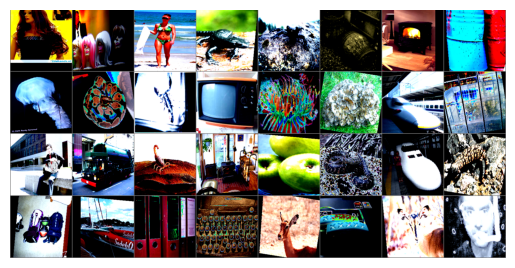

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
# set the seed for reproducibility
torch.manual_seed(42)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNet (GhostNet)                                          [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                        [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

100%|██████████| 305/305 [01:09<00:00,  4.41it/s]




Epoch: 01 | Epoch Time: 11.0m 37s
	Train Loss: 3.280 | Train Acc: 15.96%
	 Val. Loss: 2.752 |  Val. Acc: 27.05%


Best Accuracy Achieved: 27.05% on epoch 01


100%|██████████| 305/305 [00:55<00:00,  5.47it/s]




Epoch: 02 | Epoch Time: 9.0m 57s
	Train Loss: 2.788 | Train Acc: 25.78%
	 Val. Loss: 2.318 |  Val. Acc: 36.99%


Best Accuracy Achieved: 36.99% on epoch 02


100%|██████████| 305/305 [00:53<00:00,  5.73it/s]




Epoch: 03 | Epoch Time: 9.0m 42s
	Train Loss: 2.362 | Train Acc: 35.64%
	 Val. Loss: 2.093 |  Val. Acc: 42.46%


Best Accuracy Achieved: 42.46% on epoch 03


100%|██████████| 305/305 [00:51<00:00,  5.94it/s]




Epoch: 04 | Epoch Time: 9.0m 29s
	Train Loss: 2.073 | Train Acc: 43.07%
	 Val. Loss: 1.858 |  Val. Acc: 49.02%


Best Accuracy Achieved: 49.02% on epoch 04


100%|██████████| 305/305 [00:50<00:00,  5.99it/s]




Epoch: 05 | Epoch Time: 9.0m 25s
	Train Loss: 1.861 | Train Acc: 48.64%
	 Val. Loss: 1.642 |  Val. Acc: 54.22%


Best Accuracy Achieved: 54.22% on epoch 05


100%|██████████| 305/305 [00:50<00:00,  5.99it/s]




Epoch: 06 | Epoch Time: 9.0m 24s
	Train Loss: 1.702 | Train Acc: 52.85%
	 Val. Loss: 1.550 |  Val. Acc: 57.26%


Best Accuracy Achieved: 57.26% on epoch 06


100%|██████████| 305/305 [00:51<00:00,  5.92it/s]




Epoch: 07 | Epoch Time: 9.0m 24s
	Train Loss: 1.569 | Train Acc: 55.93%
	 Val. Loss: 1.477 |  Val. Acc: 58.90%


Best Accuracy Achieved: 58.90% on epoch 07


100%|██████████| 305/305 [00:50<00:00,  6.00it/s]




Epoch: 08 | Epoch Time: 9.0m 25s
	Train Loss: 1.463 | Train Acc: 58.95%
	 Val. Loss: 1.364 |  Val. Acc: 62.62%


Best Accuracy Achieved: 62.62% on epoch 08


100%|██████████| 305/305 [00:50<00:00,  5.99it/s]




Epoch: 09 | Epoch Time: 9.0m 25s
	Train Loss: 1.376 | Train Acc: 61.32%
	 Val. Loss: 1.312 |  Val. Acc: 64.44%


Best Accuracy Achieved: 64.44% on epoch 09


100%|██████████| 305/305 [00:51<00:00,  5.89it/s]




Epoch: 10 | Epoch Time: 9.0m 26s
	Train Loss: 1.288 | Train Acc: 63.55%
	 Val. Loss: 1.375 |  Val. Acc: 62.83%


100%|██████████| 305/305 [00:52<00:00,  5.77it/s]




Epoch: 11 | Epoch Time: 9.0m 29s
	Train Loss: 1.225 | Train Acc: 65.23%
	 Val. Loss: 1.242 |  Val. Acc: 65.92%


Best Accuracy Achieved: 65.92% on epoch 11


100%|██████████| 305/305 [00:53<00:00,  5.75it/s]




Epoch: 12 | Epoch Time: 9.0m 27s
	Train Loss: 1.152 | Train Acc: 66.93%
	 Val. Loss: 1.267 |  Val. Acc: 65.67%


100%|██████████| 305/305 [00:54<00:00,  5.64it/s]




Epoch: 13 | Epoch Time: 9.0m 31s
	Train Loss: 1.097 | Train Acc: 68.48%
	 Val. Loss: 1.298 |  Val. Acc: 65.64%


100%|██████████| 305/305 [00:52<00:00,  5.85it/s]




Epoch: 14 | Epoch Time: 9.0m 29s
	Train Loss: 1.044 | Train Acc: 69.63%
	 Val. Loss: 1.205 |  Val. Acc: 67.35%


Best Accuracy Achieved: 67.35% on epoch 14


100%|██████████| 305/305 [00:53<00:00,  5.68it/s]




Epoch: 15 | Epoch Time: 9.0m 30s
	Train Loss: 0.992 | Train Acc: 71.28%
	 Val. Loss: 1.198 |  Val. Acc: 68.13%


Best Accuracy Achieved: 68.13% on epoch 15


100%|██████████| 305/305 [00:53<00:00,  5.70it/s]




Epoch: 16 | Epoch Time: 9.0m 31s
	Train Loss: 0.941 | Train Acc: 72.43%
	 Val. Loss: 1.219 |  Val. Acc: 68.56%


Best Accuracy Achieved: 68.56% on epoch 16


100%|██████████| 305/305 [00:50<00:00,  6.02it/s]




Epoch: 17 | Epoch Time: 9.0m 27s
	Train Loss: 0.902 | Train Acc: 73.41%
	 Val. Loss: 1.220 |  Val. Acc: 68.09%


100%|██████████| 305/305 [00:55<00:00,  5.49it/s]




Epoch: 18 | Epoch Time: 9.0m 33s
	Train Loss: 0.861 | Train Acc: 74.69%
	 Val. Loss: 1.212 |  Val. Acc: 67.59%


100%|██████████| 305/305 [00:56<00:00,  5.43it/s]




Epoch: 19 | Epoch Time: 9.0m 56s
	Train Loss: 0.824 | Train Acc: 75.77%
	 Val. Loss: 1.271 |  Val. Acc: 67.78%


100%|██████████| 305/305 [00:55<00:00,  5.49it/s]




Epoch: 20 | Epoch Time: 9.0m 55s
	Train Loss: 0.782 | Train Acc: 76.89%
	 Val. Loss: 1.255 |  Val. Acc: 68.89%


Best Accuracy Achieved: 68.89% on epoch 20


100%|██████████| 305/305 [00:56<00:00,  5.43it/s]


Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.


Epoch: 21 | Epoch Time: 9.0m 54s
	Train Loss: 0.751 | Train Acc: 77.64%
	 Val. Loss: 1.311 |  Val. Acc: 67.05%


100%|██████████| 305/305 [00:56<00:00,  5.41it/s]




Epoch: 22 | Epoch Time: 9.0m 57s
	Train Loss: 0.470 | Train Acc: 86.00%
	 Val. Loss: 1.128 |  Val. Acc: 72.64%


Best Accuracy Achieved: 72.64% on epoch 22


100%|██████████| 305/305 [00:56<00:00,  5.41it/s]




Epoch: 23 | Epoch Time: 9.0m 55s
	Train Loss: 0.402 | Train Acc: 88.13%
	 Val. Loss: 1.169 |  Val. Acc: 73.19%


Best Accuracy Achieved: 73.19% on epoch 23


100%|██████████| 305/305 [00:56<00:00,  5.38it/s]




Epoch: 24 | Epoch Time: 9.0m 57s
	Train Loss: 0.372 | Train Acc: 88.77%
	 Val. Loss: 1.174 |  Val. Acc: 73.26%


Best Accuracy Achieved: 73.26% on epoch 24


100%|██████████| 305/305 [00:56<00:00,  5.44it/s]




Epoch: 25 | Epoch Time: 9.0m 58s
	Train Loss: 0.349 | Train Acc: 89.58%
	 Val. Loss: 1.199 |  Val. Acc: 72.86%


100%|██████████| 305/305 [00:56<00:00,  5.44it/s]




Epoch: 26 | Epoch Time: 9.0m 58s
	Train Loss: 0.333 | Train Acc: 90.20%
	 Val. Loss: 1.274 |  Val. Acc: 73.16%


100%|██████████| 305/305 [00:56<00:00,  5.39it/s]




Epoch: 27 | Epoch Time: 9.0m 59s
	Train Loss: 0.320 | Train Acc: 90.57%
	 Val. Loss: 1.255 |  Val. Acc: 73.29%


Best Accuracy Achieved: 73.29% on epoch 27


100%|██████████| 305/305 [00:56<00:00,  5.39it/s]


Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.


Epoch: 28 | Epoch Time: 10.0m 0s
	Train Loss: 0.308 | Train Acc: 90.83%
	 Val. Loss: 1.273 |  Val. Acc: 73.26%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 29 | Epoch Time: 9.0m 58s
	Train Loss: 0.282 | Train Acc: 91.75%
	 Val. Loss: 1.267 |  Val. Acc: 73.39%


Best Accuracy Achieved: 73.39% on epoch 29


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 30 | Epoch Time: 9.0m 58s
	Train Loss: 0.276 | Train Acc: 91.87%
	 Val. Loss: 1.271 |  Val. Acc: 73.60%


Best Accuracy Achieved: 73.60% on epoch 30


100%|██████████| 305/305 [00:56<00:00,  5.37it/s]




Epoch: 31 | Epoch Time: 10.0m 0s
	Train Loss: 0.273 | Train Acc: 92.03%
	 Val. Loss: 1.275 |  Val. Acc: 73.50%


100%|██████████| 305/305 [00:56<00:00,  5.42it/s]




Epoch: 32 | Epoch Time: 9.0m 59s
	Train Loss: 0.267 | Train Acc: 92.27%
	 Val. Loss: 1.288 |  Val. Acc: 73.54%


100%|██████████| 305/305 [00:56<00:00,  5.39it/s]




Epoch: 33 | Epoch Time: 9.0m 56s
	Train Loss: 0.270 | Train Acc: 92.06%
	 Val. Loss: 1.283 |  Val. Acc: 73.66%


Best Accuracy Achieved: 73.66% on epoch 33


100%|██████████| 305/305 [00:56<00:00,  5.42it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.


Epoch: 34 | Epoch Time: 9.0m 56s
	Train Loss: 0.265 | Train Acc: 92.22%
	 Val. Loss: 1.290 |  Val. Acc: 73.55%


100%|██████████| 305/305 [00:56<00:00,  5.41it/s]




Epoch: 35 | Epoch Time: 9.0m 58s
	Train Loss: 0.253 | Train Acc: 92.56%
	 Val. Loss: 1.292 |  Val. Acc: 73.56%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 36 | Epoch Time: 9.0m 58s
	Train Loss: 0.260 | Train Acc: 92.38%
	 Val. Loss: 1.293 |  Val. Acc: 73.48%


100%|██████████| 305/305 [00:56<00:00,  5.38it/s]




Epoch: 37 | Epoch Time: 9.0m 57s
	Train Loss: 0.268 | Train Acc: 92.13%
	 Val. Loss: 1.293 |  Val. Acc: 73.54%


100%|██████████| 305/305 [00:57<00:00,  5.35it/s]




Epoch: 38 | Epoch Time: 9.0m 59s
	Train Loss: 0.260 | Train Acc: 92.43%
	 Val. Loss: 1.294 |  Val. Acc: 73.51%


100%|██████████| 305/305 [00:56<00:00,  5.41it/s]




Epoch: 39 | Epoch Time: 9.0m 58s
	Train Loss: 0.263 | Train Acc: 92.44%
	 Val. Loss: 1.295 |  Val. Acc: 73.48%


100%|██████████| 305/305 [00:55<00:00,  5.45it/s]


Epoch 00040: reducing learning rate of group 0 to 1.0000e-07.


Epoch: 40 | Epoch Time: 9.0m 55s
	Train Loss: 0.266 | Train Acc: 92.25%
	 Val. Loss: 1.295 |  Val. Acc: 73.45%


100%|██████████| 305/305 [00:56<00:00,  5.39it/s]




Epoch: 41 | Epoch Time: 9.0m 57s
	Train Loss: 0.261 | Train Acc: 92.42%
	 Val. Loss: 1.295 |  Val. Acc: 73.45%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 42 | Epoch Time: 9.0m 57s
	Train Loss: 0.261 | Train Acc: 92.49%
	 Val. Loss: 1.295 |  Val. Acc: 73.45%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 43 | Epoch Time: 9.0m 56s
	Train Loss: 0.261 | Train Acc: 92.32%
	 Val. Loss: 1.295 |  Val. Acc: 73.45%


100%|██████████| 305/305 [00:56<00:00,  5.43it/s]




Epoch: 44 | Epoch Time: 9.0m 56s
	Train Loss: 0.260 | Train Acc: 92.38%
	 Val. Loss: 1.295 |  Val. Acc: 73.45%


100%|██████████| 305/305 [00:56<00:00,  5.43it/s]




Epoch: 45 | Epoch Time: 9.0m 57s
	Train Loss: 0.256 | Train Acc: 92.51%
	 Val. Loss: 1.295 |  Val. Acc: 73.41%


100%|██████████| 305/305 [00:56<00:00,  5.41it/s]


Epoch 00046: reducing learning rate of group 0 to 1.0000e-08.


Epoch: 46 | Epoch Time: 9.0m 55s
	Train Loss: 0.256 | Train Acc: 92.48%
	 Val. Loss: 1.295 |  Val. Acc: 73.44%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 47 | Epoch Time: 9.0m 56s
	Train Loss: 0.263 | Train Acc: 92.44%
	 Val. Loss: 1.295 |  Val. Acc: 73.44%


100%|██████████| 305/305 [00:56<00:00,  5.40it/s]




Epoch: 48 | Epoch Time: 9.0m 56s
	Train Loss: 0.255 | Train Acc: 92.46%
	 Val. Loss: 1.295 |  Val. Acc: 73.44%


100%|██████████| 305/305 [00:53<00:00,  5.70it/s]




Epoch: 49 | Epoch Time: 9.0m 46s
	Train Loss: 0.261 | Train Acc: 92.48%
	 Val. Loss: 1.295 |  Val. Acc: 73.44%


100%|██████████| 305/305 [00:53<00:00,  5.69it/s]




Epoch: 50 | Epoch Time: 9.0m 33s
	Train Loss: 0.260 | Train Acc: 92.39%
	 Val. Loss: 1.295 |  Val. Acc: 73.44%


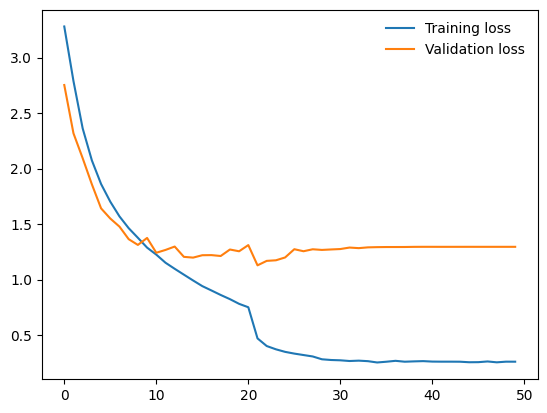

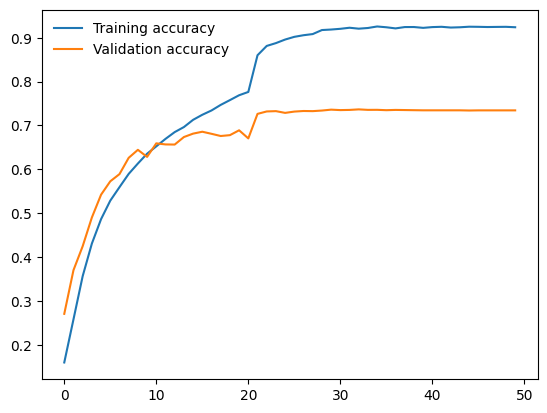

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/imagenet-50/485c9c0cd4c34138842a678150c217b7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     flops           : 45949792.0
COMET INFO:     inference_time  : 0.00559447682209504
COMET INFO:     loss [7160]     : (-2.0117533206939697, 9.874402046203613)
COMET INFO:     params          : 1187102.0
COMET INFO:     test_accuracy   : 0.7370256185531616
COMET INFO:     test_loss       : 1.2922110529832351
COMET INFO:     train_acc [50]  : (0.1595604419708252, 0.9256263971328735)
COMET INFO:     train_loss [50] : (0.25343210639141417, 3.2797893244145992)
COMET INFO:     val_acc [50]    : (0.2704615294933319, 

Test loss: 1.292.. 
Test accuracy: 0.737
Test Time: 0.0m 54s 546ms


─────────────────────────────────────────────── New Comet feature! ───────────────────────────────────────────────
Log your models to better track, deploy, share, and reproduce your work using: 'comet_ml.integration.pytorch.log_model'.
Learn more at: https://comet.com/docs/v2/pytorch_log_model

Hide this message by setting environment variable "COMET_DISABLE_ANNOUNCEMENT=1" 
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


(1.2922110529832351, tensor(0.7370, device='mps:0'))